# **SKIN CANCER DETECTION USING DEEP LEARNING**

# **Import Required Library**

In [42]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image



import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow .keras .callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# **Download Dataset**

In [3]:
#!/bin/bash
!kaggle datasets download fanconic/skin-cancer-malignant-vs-benign

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


# **Unzip Dataset**

In [4]:
! unzip /content/skin-cancer-malignant-vs-benign.zip

unzip:  cannot find or open /content/skin-cancer-malignant-vs-benign.zip, /content/skin-cancer-malignant-vs-benign.zip.zip or /content/skin-cancer-malignant-vs-benign.zip.ZIP.


## Data-Preprocessing

In [5]:
import os
from PIL import Image

def remove_corrupt_images(image_dir):
    """
    Removes corrupt images from a directory.

    Args:
      image_dir: The path to the directory containing the images.
    """
    dir = os.listdir(image_dir)
    print(dir)

    # iamge dir
    for img_folder in dir:
      print(img_folder)
      for img in os.listdir(os.path.join(image_dir, img_folder)):
        try:
          # print(img)
          img_path = os.path.join(image_dir, img_folder, img)
          img = Image.open(img_path)
          img.verify()
          img.close()
        except Exception as e:
          print(f"Corrupt Image: {img}")
          # reemove the  image
          os.remove(img_path)
          return str(e)
      print("No Corrupt Image Found in the given folder")

In [6]:
# train dir
remove_corrupt_images("/content/drive/MyDrive/Skin_Dataset/train")

['Malignant', 'Benign']
Malignant
No Corrupt Image Found in the given folder
Benign
No Corrupt Image Found in the given folder


In [7]:
# test dir
remove_corrupt_images("/content/drive/MyDrive/Skin_Dataset/test")

['Benign', 'Malignant']
Benign
No Corrupt Image Found in the given folder
Malignant
No Corrupt Image Found in the given folder


In [8]:
import matplotlib.pyplot as plt
import random
import os

# Assuming your images are in the 'train' and 'test' directories within the dataset folder
data_dir = "/content/skin-cancer-malignant-vs-benign"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

def plot_images(directory, num_images=5):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    if len(image_files) < num_images:
        print(f"Warning: Not enough images in {directory} to display {num_images}. Displaying {len(image_files)} images.")
        num_images = len(image_files)

    random_images = random.sample(image_files, num_images)

    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(random_images):
        img_path = os.path.join(directory, image_file)
        try:
            img = Image.open(img_path)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis('off')  # Hide axis
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")

    plt.tight_layout()
    plt.show()


# **Directories for training and testing data**

In [40]:
train_dir = '/content/drive/MyDrive/Skin_Dataset/train'
test_dir = '/content/drive/MyDrive/Skin_Dataset/test'


# **Load and shuffle the train data**

In [39]:
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

**Load and shuffle the test data**

In [41]:
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)


 **Select random indices for 10 images**

In [43]:
random_indices = random.sample(range(len(train_paths)), 10)


# **Create a figure to display images in 2 rows**

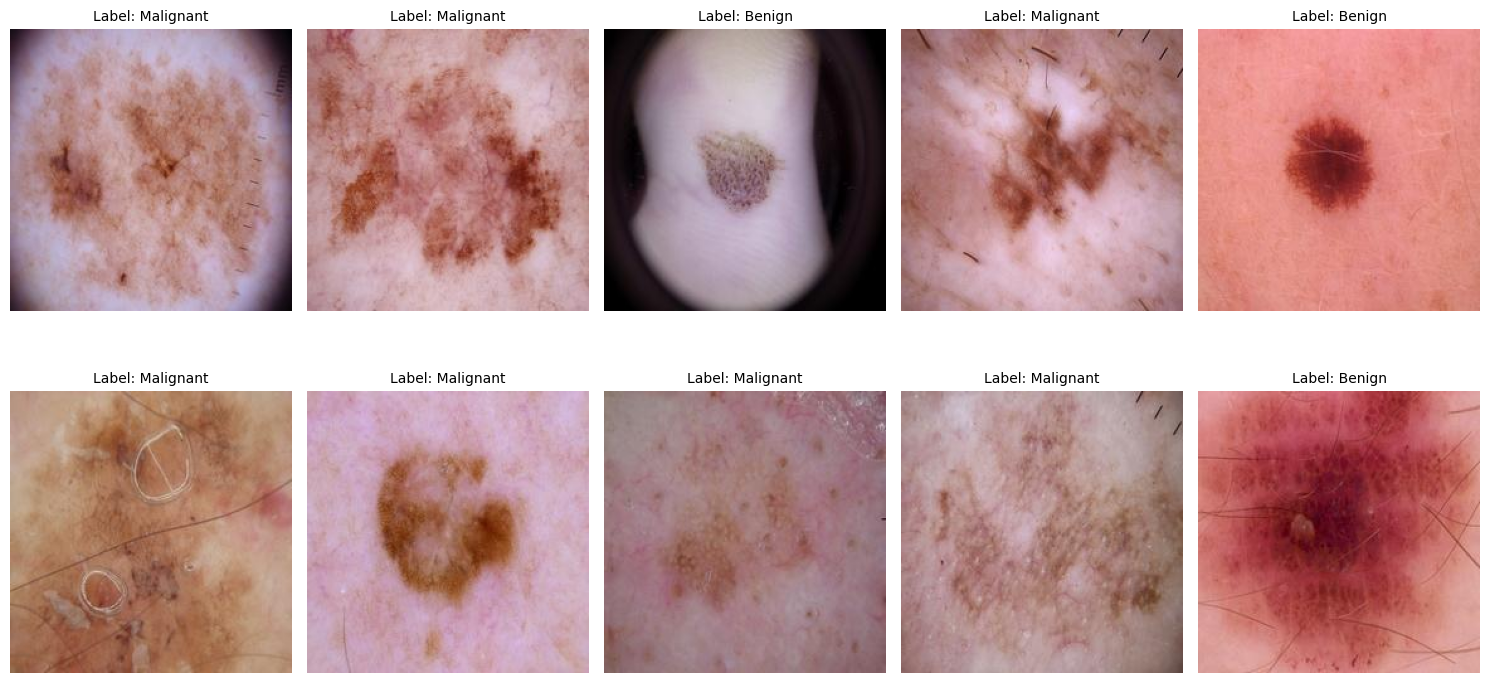

In [44]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# **Image Augmentation function**

In [45]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image


# **Load images and apply augmentation**

In [46]:
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


# **Encoding labels (convert label names to integers)**

In [47]:
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)


# **Data generator for batching**

In [48]:
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch


# **Model architecture**

In [12]:

import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 10

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - loss: 0.6543 - sparse_categorical_accuracy: 0.6715
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - loss: 0.3968 - sparse_categorical_accuracy: 0.8179
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - loss: 0.3445 - sparse_categorical_accuracy: 0.8461
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - loss: 0.2798 - sparse_categorical_accuracy: 0.8797
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - loss: 0.2340 - sparse_categorical_accuracy: 0.8913
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - loss: 0.1987 - sparse_categorical_accuracy: 0.9107
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 245s 5s/step - loss: 0.1730 - sparse_categorical_accuracy: 0.9335
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - loss: 0.1101 - sparse_categorical_accuracy: 0.9556
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - loss: 0.1359 - sparse_categorical_accuracy: 0.9511
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - loss: 0.10

In [ ]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/Skin_Dataset/train'
test_dir = '/content/drive/MyDrive/Skin_Dataset/test'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

#  **Training History**

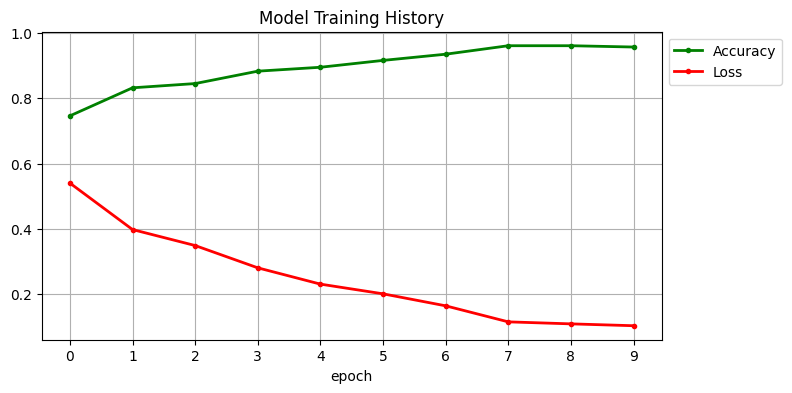

In [14]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**Classification Report**

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

32/32 ━━━━━━━━━━━━━━━━━━━━ 207s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.71       500
           1       0.71      0.64      0.67       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



# **Confusion Matrix Plot**

In [51]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[372 128]
 [182 318]]


# **Plot the Confusion Matrix**

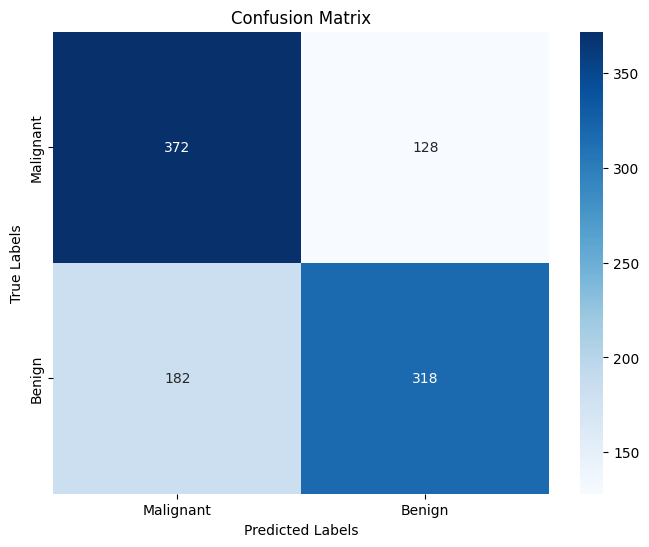

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# **Function to detect The Benign,Malgnint and display result**

In [19]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['malignant', 'benign']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'benign':
            result = "benign"
        else:
            result = f"malignantr: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


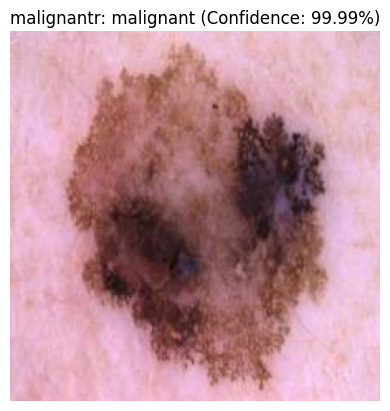

In [20]:
image_path = '/content/drive/MyDrive/Skin_Dataset/train/Malignant/101.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)